# $B_z$ extraction is simulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys
from scipy import optimize
sys.path.append("../CommonUtils/")
import CommonUtils as cu

### Define constants and starting fit parameters

In [2]:
font_size=14 # for plots 

t_min = 0 # us  #TODO 30 for data 
t_max = 100 # us 
print("Starting and end times:", t_min, "to", t_max, "us")
p_min = 1800 # MeV 
p_max = 3100 # MeV 
print("Momentum cuts:", p_min, "to", p_max, "MeV")

omega_a = 1.43934 # MHz (magic)
cu._omega=omega_a #for BNL fits
print("Magic omega set to", cu._omega, "MHz")

g2period = 2*np.pi / omega_a   # 4.3653 us 
print("g-2 period ", g2period)

bin_w = 10*1e-3 # 10 ns 
bin_n = int( round(g2period/bin_w) )
print("Setting bin width of", bin_w*1e3, "ns with", bin_n, "bins")

p0_count=(5000, 64, -0.4, 6)
print("Starting pars count (N, tau, A, phi):", *p0_count)
p0_theta=(0.00, 0.17, 0.0)
print("Starting pars count (A_Bz, A_edm, c):", *p0_theta)

Starting and end times: 0 to 100 us
Momentum cuts: 1800 to 3100 MeV
Magic omega set to 1.43934 MHz
g-2 period  4.365323903441568
Setting bin width of 10.0 ns with 437 bins
Starting pars count (N, tau, A, phi): 5000 64 -0.4 6
Starting pars count (A_Bz, A_edm, c): 0.0 0.17 0.0


### Load HDF5 data and apply time and momentum cuts

In [3]:
#long time to open 1st time
# %time data = pd.read_hdf("../DATA/HDF/Sim/VLEDM.h5", columns=("trackT0", "station", "trackMomentum", "trackMomentumY") )

# #save to open skimed
# data.to_hdf("../DATA/HDF/Sim/VLEDM_skim.h5", key="sim", mode='w', complevel=9, complib="zlib", format="fixed")

#open skimmed 
data = pd.read_hdf("../DATA/HDF/Sim/VLEDM_skim.h5")
mom_cut = ( (data['trackMomentum'] > p_min) & (data['trackMomentum'] < p_max) ) # MeV  
time_cut =( (data['trackT0'] > t_min) & (data['trackT0'] < t_max) ) # MeV  
data=data[mom_cut & time_cut]
N=data.shape[0] 
print("Total tracks", N)

#TODO for data
#define station cuts to loop over TODO fpr data
# s12_cut = (data['station'] == stations[0])
# s18_cut = (data['station'] == stations[1])
# station_cut = (s12_cut, s18_cut)

Total tracks 1106538


### Resolve variables

In [4]:
p=data['trackMomentum']
py=data['trackMomentumY']
t=data['trackT0']
mod_times = cu.get_g2_mod_time(t) # Module the g-2 oscillation time 
theta_y_mrad = np.arctan2(py, p)*1e3 # rad -> mrad
data['mod_times']=mod_times # add to the data frame 
data['theta_y_mrad']=theta_y_mrad # add to the data frame 
# data # display data 

### Digitise data

In [5]:
bin_c, freq = cu.get_freq_bin_c_from_data(mod_times, bin_w, (0, g2period) )
y_err = np.sqrt(freq) # Poissson error 

### Plot counts vs. mod time and fit

In [6]:
#set vars, fit pars, and plot
x,y,y_e = bin_c, freq, y_err
par, par_e, chi2_ndf = cu.fit_and_chi2(x, y, y_e, cu.unblinded_wiggle_fixed, p0_count)

Params: [ 2.616e+03  6.494e+01 -3.857e-01  6.295e+00]
Errors: [1.629e+01 1.172e+01 1.999e-03 1.104e-02]
𝝌2/dof=2.5


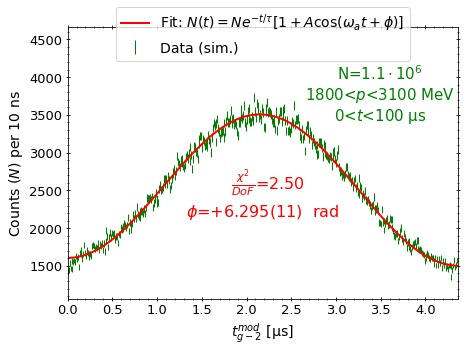

In [7]:
fig, ax = cu.plot(bin_c, freq, y_err=y_err, error=True, elw=1, label="Data (sim.)", fs=font_size, tight=False,
                  xlabel=r"$t^{mod}_{g-2} \ \mathrm{[\mu}$s]", ylabel=r"Counts ($N$) per "+str(int(bin_w*1e3))+" ns")
ax.plot(bin_c, cu.unblinded_wiggle_fixed(bin_c, *par), c="red", 
        label=r'Fit: $N(t)=Ne^{-t/\tau}[1+A\cos(\omega_at+\phi)]$', lw=2)
ax.set_xlim(0, g2period);
ax.set_ylim(np.amin(freq)*0.9, np.amax(freq)*1.25);
leg_fit=cu.legend1_fit(chi2_ndf)
leg_fit=cu.legend_1par(leg_fit, r"$\phi$", par[-1], par_e[-1], " rad", prec=3)
leg_data="N="+cu.sci_notation(N)+"\n"+str(p_min)+r"<$p$<"+str(p_max)+" MeV\n"+str(t_min)+r"<$t$<"+str(t_max)+r" $\mathrm{\mu}$s"
ax.legend(fontsize=font_size, loc='upper center', bbox_to_anchor=(0.5, 1.1));
cu.textL(ax, 0.5, 0.35, leg_fit, c="r", fs=font_size+2)
cu.textL(ax, 0.8, 0.75, leg_data, fs=font_size+1)
fig.savefig("../fig/bnl_fit.png", dpi=300)

### Set constant phase for the next step

In [8]:
cu._LT=par[1]
print("LT set to", cu._LT, "us")
cu._phi=par[3]
print("Phase set to", cu._phi, "rad")

LT set to 64.93609701719723 us
Phase set to 6.294614858789962 rad


### Profile the $\langle\theta_y\rangle$, fit and plot

In [9]:
df_binned =cu.Profile(mod_times, theta_y_mrad, None, nbins=bin_n, xmin=np.min(mod_times), xmax=np.max(mod_times), mean=True, only_binned=True)
x, y, y_e, x_e =df_binned['bincenters'], df_binned['ymean'], df_binned['yerr'], df_binned['xerr']

In [10]:
par, par_e, chi2_ndf = cu.fit_and_chi2(x, y, y_e, cu.thetaY_unblinded_phase, p0_theta)

Params: [-0.043  0.142  0.042]
Errors: [0.018 0.017 0.013]
𝝌2/dof=1.1


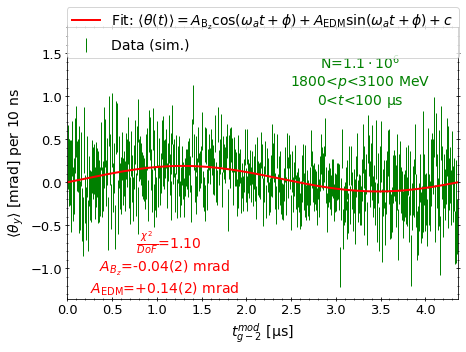

In [16]:
fig, ax = cu.plot(x, y, y_err=y_e, error=True, elw=1, label="Data (sim.)", fs=font_size, tight=False,
                  xlabel=r"$t^{mod}_{g-2} \ \mathrm{[\mu}$s]",  ylabel=r"$\langle\theta_y\rangle$ [mrad] per "+str(int(bin_w*1e3))+" ns")
ax.plot(x, cu.thetaY_unblinded_phase(x, *par), c="red", 
        label=r'Fit: $\langle \theta(t) \rangle =  A_{\mathrm{B_z}}\cos(\omega_a t + \phi) + A_{\mathrm{EDM}}\sin(\omega_a t + \phi) + c$', lw=2)
ax.set_xlim(0, g2period);
ax.set_ylim(-np.amax(y)*1.5, np.amax(y)*2.0);
leg_data="N="+cu.sci_notation(N)+"\n"+str(p_min)+r"<$p$<"+str(p_max)+" MeV\n"+str(t_min)+r"<$t$<"+str(t_max)+r" $\mathrm{\mu}$s"
ax.legend(fontsize=font_size, loc='upper center', bbox_to_anchor=(0.5, 1.1));
cu.textL(ax, 0.75, 0.8, leg_data, fs=font_size)
leg_fit=cu.legend1_fit(chi2_ndf)
leg_fit=cu.legend_1par(leg_fit, r"$A_{B_{z}}$", par[0], par_e[0], "mrad")
leg_fit=cu.legend_1par(leg_fit, r"$A_{\mathrm{EDM}}$", par[1], par_e[1], "mrad")
cu.textL(ax, 0.25, 0.1, leg_fit, fs=font_size, c="r")
fig.savefig("../fig/bz_fit.png", dpi=300)

## Now do the EDM blinding via a convolution

In [14]:
phase_offset = cu._phi/ omega_a
LT_w = cu._LT
phase_offset, LT_w

(4.373264731606127, 64.93609701719723)

In [18]:
A_bz,A_edm = par[0], par[1]
A_bz, A_edm

(-0.04341093239419058, 0.14190452025816097)

### Define functions

In [ ]:
#TODO do I need the c?

def f_edm(t, *pars):
    A_edm = pars[0]
    omega = pars[1]    
    phi   = pars[2]
    return A_edm*np.sin(omega*t+phi)

def f_bz(t, *pars):
    A_bz = pars[0]
    omega = pars[1]    
    phi   = pars[2]
    return A_bz*np.cos(omega*t+phi)

def f_ver(t, *pars):
    A_bz = pars[0]
    A_edm = pars[1]
    omega = pars[2]    
    phi   = pars[3]
    return A_bz*np.cos(omega*t+phi) + A_edm*np.sin(omega*t+phi)


    